# N-Body Simulation Performance Analysis

This notebook processes the benchmark results from the Hybrid MPI+OpenMP N-Body Simulation.
It generates the Scalability and Efficiency plots required for the technical report.

**Hardware Context:** Intel Xeon E5-2650 (10 Physical Cores).

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## 1. Load Data

In [8]:
# Load the CSV generated by scripts/benchmark.sh
df = pd.read_csv('../benchmark_results.csv')

# Calculate Total Cores
df['TotalCores'] = df['Ranks'] * df['Threads']

# Create a readable label for charts
df['Label'] = df.apply(lambda x: f"{x['Ranks']} MPI x {x['Threads']} OMP", axis=1)

print("Loaded Data Summary:")
display(df)

Loaded Data Summary:


,Config,Ranks,Threads,Time,InteractionsPerSec,TotalCores,Label
0,Pure_MPI,1,1,10.9691,45600000.0,1,1 MPI x 1 OMP
1,Pure_MPI,2,1,5.9138,84500000.0,2,2 MPI x 1 OMP
2,Pure_MPI,4,1,3.1079,161000000.0,4,4 MPI x 1 OMP
3,Pure_MPI,8,1,1.6489,303000000.0,8,8 MPI x 1 OMP
4,Pure_MPI,10,1,1.5814,316000000.0,10,10 MPI x 1 OMP
5,Hybrid_4c,2,2,3.0274,165000000.0,4,2 MPI x 2 OMP
6,Pure_OMP_4c,1,4,3.0909,162000000.0,4,1 MPI x 4 OMP
7,Hybrid_10c,2,5,1.7369,288000000.0,10,2 MPI x 5 OMP
8,Hybrid_10c,5,2,1.4778,338000000.0,10,5 MPI x 2 OMP
9,Pure_OMP_10c,1,10,1.6147,310000000.0,10,1 MPI x 10 OMP


## 2. Strong Scaling Analysis (Pure MPI)
We calculate Speedup ($T_1 / T_N$) and Efficiency ($Speedup / N$) for the Pure MPI configuration, scaling from 1 up to 10 ranks.

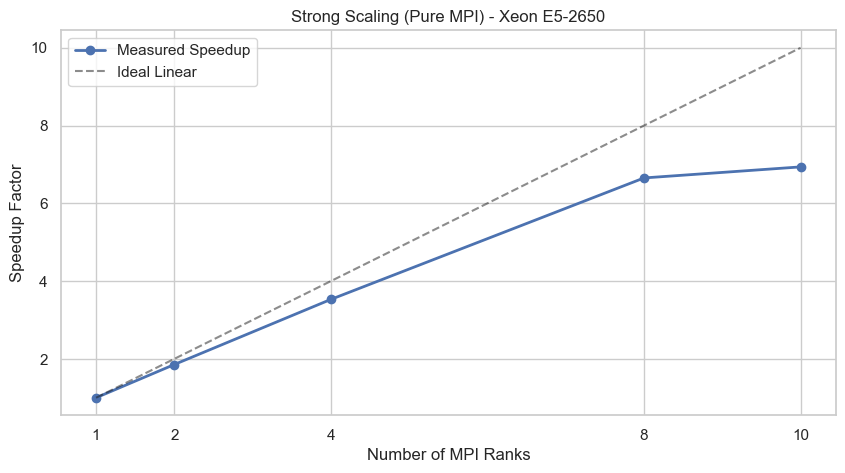

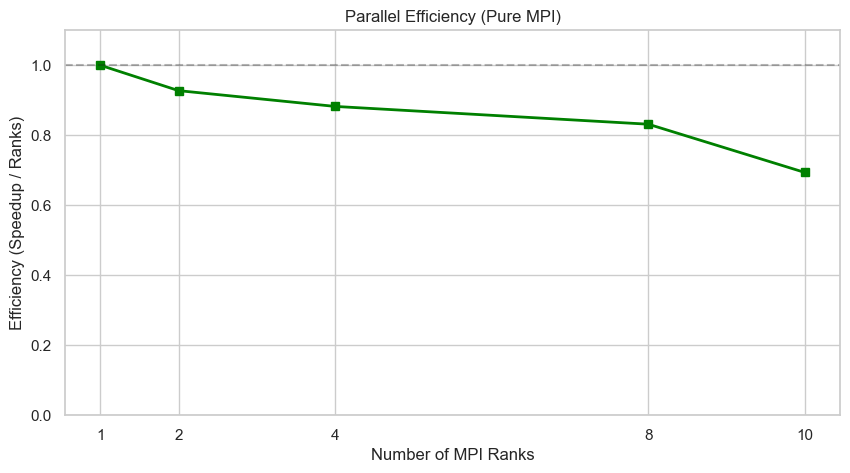

In [9]:
# Filter for Pure MPI runs (Threads == 1)
mpi_df = df[df['Config'] == 'Pure_MPI'].copy().sort_values('Ranks')

# Get baseline time (1 Rank)
t_base = mpi_df.loc[mpi_df['Ranks'] == 1, 'Time'].values[0]

# Calculate Metrics
mpi_df['Speedup'] = t_base / mpi_df['Time']
mpi_df['Efficiency'] = mpi_df['Speedup'] / mpi_df['Ranks']

# Plot Speedup
plt.figure(figsize=(10, 5))
plt.plot(mpi_df['Ranks'], mpi_df['Speedup'], marker='o', linewidth=2, label='Measured Speedup')
plt.plot(mpi_df['Ranks'], mpi_df['Ranks'], 'k--', alpha=0.5, label='Ideal Linear')

plt.title('Strong Scaling (Pure MPI) - Xeon E5-2650')
plt.xlabel('Number of MPI Ranks')
plt.ylabel('Speedup Factor')
plt.xticks(mpi_df['Ranks']) # Show only measured ticks
plt.legend()
plt.grid(True)
plt.show()

# Plot Efficiency
plt.figure(figsize=(10, 5))
plt.plot(mpi_df['Ranks'], mpi_df['Efficiency'], marker='s', color='green', linewidth=2)
plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.3)
plt.title('Parallel Efficiency (Pure MPI)')
plt.xlabel('Number of MPI Ranks')
plt.ylabel('Efficiency (Speedup / Ranks)')
plt.ylim(0, 1.1)
plt.xticks(mpi_df['Ranks'])
plt.grid(True)
plt.show()

## 3. Full Node Utilization (10 Cores)
Comparing different parallel strategies using the full capacity of the Xeon processor (10 cores).
We compare:
* **Pure MPI**: 10 Processes
* **Hybrid Balanced**: 5 MPI x 2 OpenMP
* **Hybrid Thread-Heavy**: 2 MPI x 5 OpenMP
* **Pure OpenMP**: 1 Process x 10 Threads

/tmp/ipykernel_154439/1106409807.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Time', data=node_df, palette='viridis')


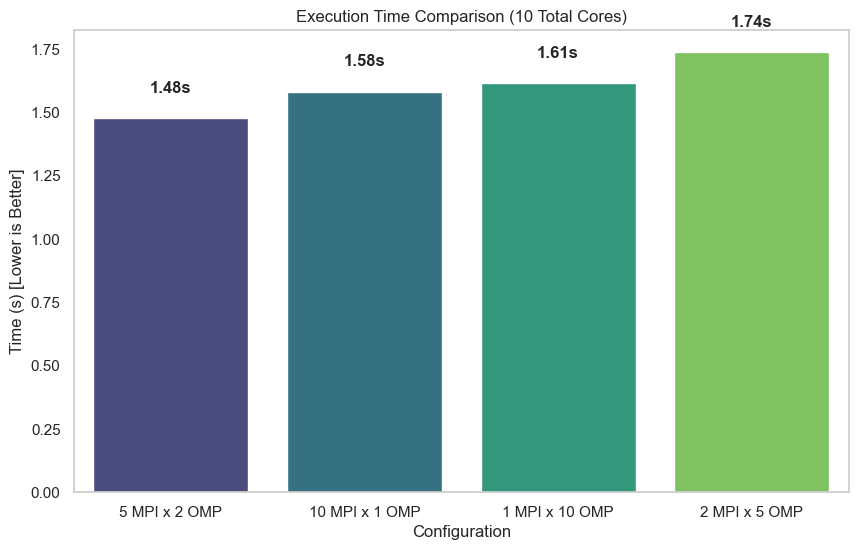

Performance Table (Interactions/sec):


,Label,Time,InteractionsPerSec
8,5 MPI x 2 OMP,1.4778,338000000.0
4,10 MPI x 1 OMP,1.5814,316000000.0
9,1 MPI x 10 OMP,1.6147,310000000.0
7,2 MPI x 5 OMP,1.7369,288000000.0


In [10]:
# Filter for runs that use exactly 10 cores
node_df = df[df['TotalCores'] == 10].copy().sort_values('Time')

if not node_df.empty:
    plt.figure(figsize=(10, 6))
    
    # Create Bar Chart
    ax = sns.barplot(x='Label', y='Time', data=node_df, palette='viridis')
    
    plt.title('Execution Time Comparison (10 Total Cores)')
    plt.ylabel('Time (s) [Lower is Better]')
    plt.xlabel('Configuration')
    plt.grid(axis='y')
    
    # Add value labels on top of bars
    for i, v in enumerate(node_df['Time']):
        ax.text(i, v + 0.1, f"{v:.2f}s", ha='center', fontweight='bold')
        
    plt.show()
    
    # Calculate interactions per second comparison
    print("Performance Table (Interactions/sec):")
    display(node_df[['Label', 'Time', 'InteractionsPerSec']].sort_values('InteractionsPerSec', ascending=False))
else:
    print("No 10-core data found. Did you run the updated benchmark.sh?")

## 4. 4-Core Comparison (Small Scale)
Verifying hybrid overheads at smaller scale.

/tmp/ipykernel_154439/3265540837.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Time', data=small_df, palette='rocket')


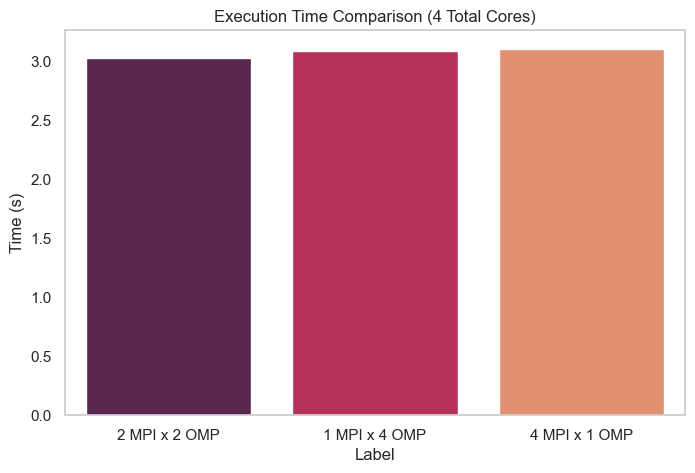

In [11]:
small_df = df[df['TotalCores'] == 4].copy().sort_values('Time')

if not small_df.empty:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Label', y='Time', data=small_df, palette='rocket')
    plt.title('Execution Time Comparison (4 Total Cores)')
    plt.ylabel('Time (s)')
    plt.grid(axis='y')
    plt.show()
else:
    print("No 4-core data found.")